# **Chapter 2. Fundamentals**
---
---

In Chapter 1, I described th major conceptual building block for understanding deep learning: nasted continuous, differentiable functions. I showed how to represent these functions as computational graphs, with each node in a graph representating a single, simple function. In particular, I demonstrated that such a representation showed easily how to calculate the derivative of the output of the nasted function with respect to its input: we simply take the derivatives of all the constituent functions, evaluate these derivatives as the input that these functions recived, and then multiply all of the results together; this will result in a correct derivative for the nested functions because of the chain rule. I illustrated that this does in fact work with some simple examples, with functions that took `NumPy's ndarrays` as inputs and produced `ndarrays` as outputs.

I showed that this method of computing derivatives works even when the function takes in multiple `ndarrays` as inputs and combines them via a *matrix multiplication* operation, which, unlike the other operations we saw, changes the shape of its inputs. Specifically, if one input to this operation—call the input $X$—is a `B × N ndarray`, and another input to this operation, $W$, is an `N × M ndarray`, then its output $P$ is a `B × M ndarray`. While it isn’t clear what the derivative of such an operation would be, I showed that when a matrix multiplication $v(X, W)$ is included as a “constituent operation” in a nested function, we can still use a simple expression *in place of* its derivative to compute the derivatives of its inputs: specifically, the role of $\frac{\partial v}{\partial u}(W)$ can be filled by $X^T$, and the role of $\frac{\partial v}{\partial u}(X)$ can be played by $W^T$.

In this chapter, we’ll start translating these concepts into real-world applications, Specifically, we will:

1. Express linear regression in terms of these building blocks
2. Show that the reasoning around derivatives that we did in Chapter 1 allows us to train this linear regression model
3. Extend this model (still using our building blocks) to a one-layer neural network

Then, in Chapter 3, it will be straightforward to use these same building blocks to build deep learning models.

Before we dive into all this, though, let’s give an overview of *supervised learning*, the subset of machine learning that we’ll focus on as we see how to use neural networks to solve problems.

## # Supervised Learning Overview
---

At a high level, machine learning can be described as building algorithms that can uncover or “learn” *relationships* in data; supervised learning can be described as the subset of machine learning dedicated to finding relationships *between characteristics of the data that have already been measured.*

In this chapter, we'll deal with a typical supervised learning problem that you might encounter in the real world: finding the relationship between characteristics of a house and the value of the house. Clearly, there is some relationship between characteristics such as the number of rooms, the square footage, or the proximity to schools and how desirable a house is to live in or own. At a high level, the aim of supervised learning is to uncover these relationships, given that we've *already measured* these characteristics.

By "measure", I mean that each characteristic has been defined precisely and represented as a number. Many characteristics of a house, such as the number of bedrooms, the square footage, and so on, naturally lend themselves to being represented as numbers, but if we had other, different kinds of information, such as natural language descriptions of the house’s neighborhood from TripAdvisor, this part of the problem would be much less straightforward, and doing the translation of this less-structured data into numbers in a reasonable way could make or break our ability to uncover relationships. In addition, for any concept that is ambiguously defined, such as the value of a house, we simply have to pick a single number to describe it; here, an obvious choice is to use the price of the house.

Once we’ve translated our “characteristics” into numbers, we have to decide what structure to use to represent these numbers. One that is nearly universal across machine learning and turns out to make computations easy is to represent each set of numbers for a single observation—for example, a single house—as a row of data, and then stack these rows on top of each other to form “batches” of data that will get fed into our models as two-dimensional `ndarrays`. Our models will then return predictions as output `ndarrays` with each prediction in a row, similarly stacked on top of each other, with one prediction for each observation in the batch.

Now for some definitions: we say that the length of each row in this `ndarray` is the number of *features* of our data. In general, a single characteristic can map to many features, a classic example being a characteristic that describes our data as belonging to one of several *categories*, such as being a red brick house, a tan brick house, or a slate house; in this specific case we might describe this single characteristic with three features. The process of mapping what we informally think of as characteristics of our observations into features is called *feature engineering*. I won’t spend much time discussing this process in this book; indeed, in this chapter we’ll deal with a problem in which we have 13 characteristics of each observation, and we simply represent each characteristic with a single numeric feature.

I said that the goal of supervised learning is ultimately to uncover relationships between characteristics of data. In practice, we do this by choosing one characteristic that we want to predict from the others; we call this characteristic our *target*. The choice of which characteristic to use as the target is completely arbitrary and depends on the problem you are trying to solve. For example, if your goal is just to *describe* the relationship between the prices of houses and the number of rooms they have, you could do this by training a model with the prices of houses as the target and the number of rooms as a feature, or vice versa; either way, the resulting model will indeed contain a description of the relationship between these two characteristics, allowing you to say, for example, a higher number of rooms in a house is associated with higher prices. On the other hand, if your goal is to *predict* the prices of houses *for which no price information is available*, you have to choose the price as your target, so that you can ultimately feed the other information into your model once it is trained.

Figure 2-1 shows this hierarchy of descriptions of supervised learning, from the highest-level description of finding relationships in data, to the lowest level of quantifying those relationships by training models to uncover numerical representations between the features and the target.

<div align="center">
    <img src="https://learning.oreilly.com/library/view/deep-learning-from/9781492041405/assets/dlfs_0201.png" width="600px"/>
    <i>Figure 2-1. Supervised learning overview</i>
</div>

As mentioned, we’ll spend almost all our time on the level highlighted at the bottom of Figure 2-1; nevertheless, in many problems, getting the parts at the top correct—collecting the right data, defining the problem you are trying to solve, and doing feature engineering—is much harder than the actual modeling. Still, since this book is focused on modeling—specifically, on understanding how deep learning models work—let’s return to that subject.

## #  Supervised Learning Models
---

Now we know at a high level what supervised learning models are trying to do—and as I alluded to earlier in the chapter, such models are just nested, mathematical functions. We spent the last chapter seeing how to represent such functions in terms of diagrams, math, and code, so now I can state the goal of supervised learning more precisely in terms of both math and code (I’ll show plenty of diagrams later): the goal is to *find* (a mathematical function) / (a function that takes an `ndarray` as input and produces an `ndarray` as output) that can (map characteristics of observations to the target) / (given an input `ndarray` containing the features we created, produce an output `ndarray` whose values are “close to” the `ndarray` containing the target).

Specifically, our data will be represented in a matrix $X$ with $n$ rows, each of which represents an observation with $k$ features, all of which are numbers. Each row observation will be a vector, as in $x_i = \begin{bmatrix}x_{i1} & x_{i2} & x_{i3} & \cdots & x_{ik}\end{bmatrix}$, and these observations will be stacked on top of one another to form a batch. For example, a batch of size 3 would look like:

$$ X_{batch} = \begin{bmatrix}
x_{11} & x_{12} & x_{13} & \ldots & x_{1k} \\
x_{21} & x_{22} & x_{23} & \ldots & x_{2k} \\
x_{31} & x_{32} & x_{33} & \ldots & x_{3k}
\end{bmatrix} $$

For each batch of observations, we will have a corresponding batch of *target*, each element of which is the target number for the corresponding observation, We can represent these in a one-dimensional vector:

$$ \begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix} $$

In terms of these arrays, our goal with supervised learning will be to use the tools I described in the last chapter to buils a function that can take as input batches of observations with the structure of $X_{batch}$ and produce vectors of values $p_i$—which we’ll interpret as “predictions”—that (for data in our particular dataset $X$, at least) are “close to the target values” $y_i$ for some reasonable measure of closeness.

Finally, we are ready to make all of this concrete and start building our first model for a real-world dataset. We’ll start with a straightforward model—*linear regression*—and show how to express it in terms of the building blocks from the prior chapter.

## # Linear Regression
---

Linear regression is often shown as:

$$ y_i = \beta_0 + \beta_1 \times x_1 + \cdots + \beta_n \times x_k + \epsilon$$

This representation describes mathematically our belief that the numeric value of each target is a linear combination of the $k$ features of $X$, plus the $\beta_0$ term to adjust the “baseline” value of the prediction (specifically, the prediction that will be made when the value of all of the features is 0).

This, of course, doesn’t give us much insight into how we would code this up so that we could “train” such a model. To do that, we have to translate this model into the language of the functions we saw in Chapter 1; the best place to start is with a diagram.

### ## Linear Regeression: A Digram

How can we represent linear regression as a computational graph? We *could* break it down all the way to the individual elements, with each $x_i$ being multiplied by another element $w_i$ and then the results being added together, as in Figure 2-2.

<div align="center">
    <img src="https://learning.oreilly.com/library/view/deep-learning-from/9781492041405/assets/dlfs_0202.png" width="600px"/>
    <i>Figure 2-2. The operations of a linear regression shown at the level of individual multiplications and additions</i>
</div>

But again, as we saw in Chapter 1, if we can represent these operations as just a matrix multiplication, we’ll be able to write the function more concisely while still being able to correctly calculate the derivative of the output with respect to the input, which will allow us to train the model.

How can we do this? First, let’s handle the simpler scenario in which we don’t have an intercept term ($\beta_0$ shown previously). Note that we can represent the output of a linear regression model as the *dot product* of each observation vector $x_i = \begin{bmatrix}x_{i1} & x_{i2} & x_{i3} & \cdots & x_{ik}\end{bmatrix}$ with another vector of parameters that we’ll call $W$:

$$ W = \begin{bmatrix}
w_1 \\
w_2 \\
w_3 \\
\vdots \\
w_k
\end{bmatrix} $$

Our prediction would then simply be:

$$ p_i = x_i \times W + b = w_1 \times x_{i1} + w_2 \times x_{i2} + \ldots + w_k \times x_{ik} + b $$

So, we can represent “generating the predictions” for a linear regression using a single operation: the dot product.

Furthermore, when we want to make predictions using linear regression with a batch of observations, we can use another, single operation: the matrix multiplication. If we have a batch of size 3, for example:

$$ X_{batch} = \begin{bmatrix}
x_{11} & x_{12} & x_{13} & \ldots & x_{1k} \\
x_{21} & x_{22} & x_{23} & \ldots & x_{2k} \\
x_{31} & x_{32} & x_{33} & \ldots & x_{3k}
\end{bmatrix} $$

then performing the *matrix multiplication* of this batch $X_{batch}$ with $W$ gives a vector of predictions for the batch, as desired:

$$ p_{batch} = X_{batch} \times W = \begin{bmatrix}
x_{11} & x_{12} & x_{13} & \cdots & x_{1k} \\
x_{21} & x_{22} & x_{23} & \cdots & x_{2k} \\
x_{31} & x_{32} & x_{33} & \cdots & x_{3k}
\end{bmatrix} \times \begin{bmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_k  \end{bmatrix}
=
\begin{bmatrix}
x_{11} \times w_1 + x_{12} \times w_2 + x_{13} \times w_3 + \cdots + & x_{1k} \times w_k \\
x_{21} \times w_1 + x_{22} \times w_2 + x_{23} \times w_3 + \cdots + & x_{2k} \times w_k \\
x_{31} \times w_1 + x_{32} \times w_2 + x_{33} \times w_3 + \cdots + & x_{3k} \times w_k
\end{bmatrix}
=
\begin{bmatrix}
p_1 \\
p_2 \\
p_3
\end{bmatrix} $$

So generating predictions for a batch of observations in a linear regression can be done with a matrix multiplication. Next, I’ll show how to use this fact, along with the reasoning about derivatives from the prior chapter, to train this model.

### ## "TRAINING" THIS MODEL

What does it mean to "train" a model? At a high level, models take in data, combine them with *paramaeters* in some way, and produce predictions. For example, the linear regression model shown earlier takes in data &X& and parameters &W& and produces the predictions $p_{batch}$ using a matrix multiplication:

$$ p_{batch} = \begin{bmatrix}
p_1 \\
p_2 \\
p_3 
\end{bmatrix} $$

To train our mode, however, we need another crucial piece of information: whether or not these predictions are goods. To learn this, we bring in the vector of $targets$ $y_{batch}$ associated with the batch of observations $X_{batch}$ fed into the function, adn we compute a * single number* that is a function of $y_{batch}$ and $p_{batch}$ adn that represents the model's "penalty" for making the predictions that it did. A reasonable choice is *mean squared error*, which is simply the average squared value that our model's predictions "missed" by:

$$ MSE(p_{batch}, y_{batch}) = MSE \left(\begin{bmatrix}
p_1 \\
p_2 \\
p_3
\end{bmatrix}, \begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix}\right) = \frac{(y_1 - p_1)^2 + (y_2 - p_2)^2 + (y_3 - p_3)^2}{3} $$

Getting to this number, which we can call $L$, is key: once we have it, we can use all the techniques we saw in Chapter 1 to compute the gradient of this number with respect to each element of W. Then *we can use these derivatives to update each element of* $W$ *in the direction that would cause* $L$ *to decrease*. Repeating this procedure many times, we hope, will “train” our model; in this chapter, we’ll see that this can indeed work in practice. To see clearly how to compute these gradients, we’ll complete the process of representing linear regression as a computational graph.

### ## Linear Regression: A more Helpful Digram (and the Math)

Figure 2-3 shows how to represent linear regression in terms of the diagrams from the last chapter.

<div align="center">
    <img src="https://learning.oreilly.com/library/view/deep-learning-from/9781492041405/assets/dlfs_0203.png" width="600px"/>
    <i>Figure 2-3. The linear regression equations expressed as a computational graph—the dark blue letters are the data inputs to the function, and the light blue W denotes the weights</i>
</div>

Finally, to reinforce that we’re still representing a nested mathematical function with this diagram, we could represent the loss value L that we ultimately compute as:

$$ L = \Lambda((v(X,W),Y) $$

### ## Adding in the Intercept

Reresenting models as digrams shows us conceptually how we can add an intercept to the model. We simply add an extra step at the end that involve adding a "bias", as shown in Figure 2-4.

<div align="center">
    <img src="https://learning.oreilly.com/library/view/deep-learning-from/9781492041405/assets/dlfs_0204.png" width="600px"/>
    <i>Figure 2-4. The computational graph of linear regression, with the addition of a bias term at the end</i>
</div>

Here, though, we should reason mathematically about what is going on before moving on to the code; with the bias added, each element of our model’s prediction $p_i$ will be the dot product described earlier with the quantity $b$ added to it:

$$ p_{batch\_with\_bias} = x_i dot W + b =
\begin{bmatrix}
x_{11} \times w_1 + x_{12} \times w_2 + x_{13} \times w_3 + \ldots + & x_{1k} \times w_k + b \\
x_{21} \times w_1 + x_{22} \times w_2 + x_{23} \times w_3 + \ldots + & x_{2k} \times w_k + b\\
x_{31} \times w_1 + x_{32} \times w_2 + x_{33} \times w_3 + \ldots + & x_{3k} \times w_k + b
\end{bmatrix}
=
\begin{bmatrix}
p_1 \\
p_2 \\
p_3
\end{bmatrix} $$

Note that because the intercept in linear regression should be just a single number rather than being different for each observation, the *same number* should get added to each observation of the input to the bias operation that is passed in; we’ll discuss what this means for computing the derivatives in a later section of this chapter.

### ## Linear regression: The Code

We'll now tie this together and code up the function that makes predictions and computes losses given batches of observations $X_{batch}$ and their corresponding tergets $y_{batch}$. Recall that computing derivatives for nested functions using the chain rule involves two sets of steps: first, we perform a “forward pass,” passing the input successively forward through a series of operations and saving the quantities computed as we go; then we use those quantities to compute the appropriate derivatives during the backward pass.

The following code does this, saving the quantities computed on the forward pass in a dictionary; furthermore, to differentiate between the quantities computed on the forward pass and the parameters themselves (which we’ll also need for the backward pass), our function will expect to receive a dictionary containing the parameters:

In [1]:
import os
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TEST_ALL = False
GRAPHS_IMG_FILEPATH = os.path.join("asset", "chapter_2", "images")

In [4]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                             ) -> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by_step linear regression.
    '''
    
    # assert batch size of X adn y are equal
    assert X_batch.shape[0] == y_batch.shape[0]
    
    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]
    
    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1
    
    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y_batch - P, 2))
    
    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return loss, forward_info

Now we have all the pieces in place to start "training" this model. Next, we'll cover exactly what this means and how we'll do it.

## # Training the Model
---

We are now going to use all the tools we learned in the last chapter to compute $\frac{\partial L}{\partial w_t}$ for every $w_i$ in $W$, as well as $\frac{\partial L}{\partial b}$. How? Well, since the "forward pass" of this functions was passing the input through a series of nasted functions, the backward pass will simply involve computing the partial derivatives of each function, evaluating thos derivatives at the functions inputs, and multiplying them togetger—and even though a matrix multiplication is involved, we’ll be able to handle this using the reasoning we covered in the last chapter.

### ## Calculating the Gradients: A Diagram

Conceptually, we want something like what is depicted in Figure 2-5

<div align="center">
    <img src="https://learning.oreilly.com/library/view/deep-learning-from/9781492041405/assets/dlfs_0205.png" width="600px"/>
    <i>Figure 2-5. The backward pass through the linear regression computational graph</i>
</div>

We simply step backward, computing the derivative of each constituent function and evaluating those derivatives at the inputs that those functions recived on the forward pass, and then multiplying these derivatives togteher at the end. This is straighforward enaugh, so let's get into the details.

### ## Claculating the Gradients: The math (and Some Code)

From Figure 2-5, we can see that the derivative product that we ultimately want to compute is:

$$ \frac{\partial \Lambda}{\partial P}(P,Y) \times \frac{\partial \alpha}{\partial N}(N,B) \times \frac{\partial v}{\partial W}(X,W) $$

There are three components here; let’s compute each of them in turn.

First up: $\frac{\partial \Lambda}{\partial P}(P,Y)$. Since $\Lambda (P,Y) = (Y - P)^2$ for each element in $Y$ and $P$:

$$ \frac{\partial \Lambda}{\partial P}(P,Y) = -1 \times (2 \times (Y - P)) $$

We're jumping ahead of ourselves a bit, but note that coding this up would simply be:

```python
dLdP = -2 * (Y - P)
```

Next, we have an expression involving matrices: $\frac{\partial \alpha}{\partial N}(N,B)$. But since $\alpha$ is just addition, the same logic that we reasoned through with numbers in the prior chapter applies here: increasing any element of N by one unit will increase $P = \alpha (N, B) = N + B$ by one unit. Thus, $\frac{\partial \alpha}{\partial N}(N,B)$ is just a matrix of$+1+s$, of the same shape as $N$.

Coding *this* expression, therefore, would simply be:

```python
dPdN = np.ones_like(N)
```

Finally, we have $\frac{\partial v}{\partial W}(X,W)$. As we discussed in detail in the last chapter, when computing derivatives of nested functions where one of the constituent functions is a matrix multiplication, we can act *as if*:

$$ \frac{\partial v}{\partial W}(X,W) = X^T $$

which in code is simply:

```python
dNdW = np.transpose(X, (1, 0))
```

We’ll do the same for the intercept term; since we are just adding it, the partial derivative of the intercept term with respect to the output is simply 1:

```python
dPdB = np.ones_likes(wights['B'])
```

The last step is to simply multiply these together, making sure we use the correct order for the matrix multiplications involving `dNdW` and `dNdX` based on what we reasoned through at the end of the last chapter.

### ## Calculating th Gradients: The (Full) Code

Recall tha our goal is to take everything computed on or inputed into the forward pass—which, from the diagram in Figure 2-5, will include $X, W, B, P$ and $y$—and compute $\frac{\partial \Lambda}{\partial W}$ and $\frac{\partial \Lambda}{\partial B}$. The following code does that, receiving $W$ and $B$ as inputs in a dictionary called `weights` and the rest of the quantities in a dictionary called `forward_info`:

In [5]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]
    
    dLdP = -2 * (forward_info['y'] - forward_info['P'])
    
    dPdN = np.ones_like(forward_info['N'])
    
    dPdB = np.ones_like(weights['B'])
    
    dLdN = dLdP * dPdN
    
    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # Need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)
    dLdW = np.dot(dNdW, dLdN)
    
    # need to sum along dimension representing the batch seize
    dLdB = (dLdP * dPdB).sum(axis=0)
    
    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB
    
    return loss_gradients

As you can see, we simply compute the derivatives with respect to each operation and successively multiply them together, taking care that we do the matrix multiplication in the right order. As we’ll see shortly, this actually works—and after the intuition we built up around the chain rule in the last chapter, this shouldn’t be too surprising.

---
<h3 align="center"><strong>NOTE</strong></h3>

An implementation detail about those loss gradients: we’re storing them as a dictionary, with the names of the weights as keys and the amounts that increasing the weights affect the losses as values. The `weights` dictionary is structured the same way. Therefore, we’ll iterate through the weights in our model in the following way:

```python
for key in weights.keys():
    weights[key] -= learning_rate * loss_grads[key]
```

There is nothing special about storing them in this way; if we stored them differntly, we sould simply iterate through them and refer to them differently.

---

### ## Using These Gradients to Train Model

Now we'll simply run the following procedure over and over again:
1. Select a batch of data.
2. Run the forward pass of the model.
3. Run the backward pass of the model using the info computed on the forward pass.
4. Use the gradients computed on the backward pass to update the weights.

The key lines, which get repeated inside of a for loop, are these:

```python
forward_info, loss = forward_loss(X_batch, y_batch, weights)

loss_grads = loss_gradients(forward_info, weights)

for key in weights.keys():  # 'weights' and 'loss_grads' have the same keys
    weights[key] -= learning_rate * loss_grads[key]
```

Then we run the `train` function for a certain number of *epochs*, or cycles through the entire training dataset, as follows:

```python
train_info = train(X_train, y_train,
                   learing_rate = 0.001,
                   batch_size = 23,
                   return_weights = True,
                   seed = 80718)
```


The train function returns `train_info, a Tuple`, one element of which is the parameters or *weights* that represent what the model has learned.

---
<h3 align="center"><strong>NOTE</strong></h3>

The terms "parameters" and "weights" are used interchangeably throught deep learning, so we will use them interchangeably in this book.

---

In [6]:
def to_2d_np(a: ndarray, 
             type: str = "col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''
    
    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [7]:
def permute_data(X: ndarray,
                 y: ndarray):
    '''
    Permute X and y, using the same permuatation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [8]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray,
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    
    assert X.ndim == y.ndim == 2, \
    "X and y must be 2 dimensional"
    
    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
        
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [9]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) ->Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss for a step-by-step linear regression
    (used mostly during inference).
    '''
    N = np.dot(X, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y - P, 2))
    
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y
    
    return forward_info, loss

In [10]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B
    
    return weights

In [11]:
def train(X: ndarray, 
          y: ndarray,
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False,
          return_weights: bool = False,
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    
    if seed:
        np.random.seed(seed)
    start = 0
    
    # initialize weights
    weights = init_weights(X.shape[1])
    
    # permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []
        
    for i in range(n_iter):
        
        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
            
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
        
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads = loss_gradients(forward_info, weights)
        
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
            
    if return_weights:
        return losses, weights
    
    return None

In [12]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
boston = load_boston()

In [14]:
data = boston.data
target = boston.target
features = boston.feature_names

In [15]:
s = StandardScaler()
data = s.fit_transform(data)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [17]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)

losses = train_info[0]
weights = train_info[1]

In [18]:
import matplotlib.pyplot as plt

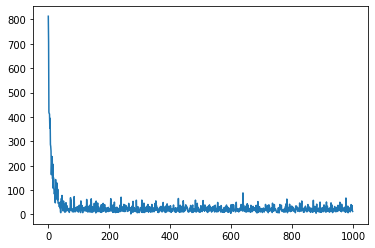

In [19]:
plt.plot(list(range(1000)), losses);